# Classification: Point Trajectory

Exploring the trajectory of each facial point caputred by nuiCapture as a candidate feature.

<p>
    <img src="nuicapture.png">
    <em>Source: CadavidConcepts</em>
</p>

In [3]:
import glob as gl
import numpy as np
from scipy.io import loadmat
from typing import List
import pandas as pd
from scipy.spatial import distance
import matplotlib.pyplot as plt
%matplotlib notebook

In [4]:
def labelname(file_name):  # Extract labels from filenames 
    label = file_name.replace("data/fundamental/sample", "").lower()
    label = label.replace(".mat", "").lower()
    label = label.split('-', 1)[-1]
    return label


class Signal:  # Signal representation containing x and y coordinates and corresponding label
    def __init__(self, x, y, label):
        self.x = x
        self.y = y
        self.label = label
        
    
def trajectory(sig):
    points_x = np.array(np.split(sig.x, 121, axis=1))
    points_y = np.array(np.split(sig.y, 121, axis=1))
    
    npoints, nrecs, nframes = np.shape(points_x)
    
    distances = np.empty((nrecs, npoints))
    
    # TO DO: normalizar
    # Calcula distância euclidiana entre (x,y) do frame atual e (x,y) do próximo frame
    # Resultado é registrado como soma acumulada das distâncias percorridas por cada ponto entre frames
    for r in range(nrecs):
        for p in range(npoints):
            distances[r][p] = 0
            for f in range(nframes-1):
                current_frame = [points_x[p, r, f], points_y[p, r, f]]
                next_frame = [points_x[p, r, f+1], points_y[p, r, f+1]]
                distances[r][p] += distance.euclidean(current_frame, next_frame)
    
    return np.argsort(-distances, axis=1)

In [6]:
files = gl.glob("data/fundamental/*.mat")  # type: list
signals = []  # type: List[Signal]

for f in files:
    data = loadmat(f).get('pontosSinal')
    signals.append(Signal(data[:, ::2], data[:, 1::2], labelname(f)))

nsigns = len(signals)
nrecs, n_x = np.shape(signals[0].x)  # Number of recordings and number of features
nframes = 5

signals_feat = []  # Updated signals, according to each experiment
signals_labels = []
labels_dict = {'angry': 1, 'disgusted': 2, 'fearful': 3, 'happy': 4, 'sad': 5, 'surprised': 6, 
               'neutral': 7, 'suckedcheeks': 8, 'inflatedcheeks': 9}  # Dictionary of signals' labels, for reference

for s in signals:
    signals_feat.append(trajectory(s))
    signals_labels.append([labels_dict[s.label]] * nrecs)

signals_feat = pd.DataFrame(data=np.vstack(signals_feat)) # 100 x 121

sig_mode = []

i = 0
for s in signals:
    sig_sorted = pd.DataFrame(np.sort(np.array(signals_feat.loc[i*10:(i*10+9), 0:11]), axis=1))
    sig_mode.append(sig_sorted.mode(axis=0).loc[0,:].astype(int))
    i += 1

sig_mode = pd.DataFrame(data=sig_mode)
sig_labels = np.reshape(signals_labels, (nsigns * nrecs,))

In [4]:
# Moda dos 10% pontos de maior distância acumulada para cada sinal
# Gravações que mais se diferenciam da moda
# Número de pontos diferentes da moda

for i in range(nsigns):
    print("Signal: ", signals[i].label)
    result_sorted = pd.DataFrame(np.sort(np.array(signals_feat.loc[i*10:(i*10+9), 0:11]), axis=1))
    print(np.shape(result_sorted))
    result_mode = result_sorted.mode(axis=0).loc[0,:]
    print("Mode: ", np.array(result_mode.astype(int)))
    distance_mode = []
    for j in range(nrecs):
        distance_mode.append(len(result_mode) - len(list(set(result_sorted.loc[j,:]).intersection(result_mode))))
    distance_mode = np.array(distance_mode)
    index = (np.argsort(-distance_mode))[0:3]
    print("Most distant from mode: ", np.sort(np.array(index)))
    print(pd.DataFrame(data=distance_mode.astype(int)))
    print()

Signal:  acalmar
(10, 12)
Mode:  [  2  19  20  43  44  47  68  71  81  92 116 120]
Most distant from mode:  [0 6 7]
   0
0  2
1  1
2  1
3  0
4  1
5  1
6  2
7  3
8  2
9  1

Signal:  acusar
(10, 12)
Mode:  [  2  19  20  26  43  44  57  57  68  81  92 116]
Most distant from mode:  [0 1 2]
   0
0  2
1  1
2  2
3  1
4  1
5  1
6  1
7  1
8  1
9  1

Signal:  aniquilar
(10, 12)
Mode:  [  2  19  20  26  43  44  50  57  68  81  92 116]
Most distant from mode:  [0 2 7]
   0
0  1
1  0
2  1
3  0
4  1
5  0
6  0
7  2
8  0
9  1

Signal:  apaixonado
(10, 12)
Mode:  [  2  19  20  26  43  44  57  57  68  81  92 116]
Most distant from mode:  [1 2 7]
   0
0  1
1  3
2  3
3  1
4  1
5  1
6  1
7  4
8  1
9  1

Signal:  engordar
(10, 12)
Mode:  [  2  19  20  26  43  44  57  57  68  81  92 116]
Most distant from mode:  [0 1 2]
   0
0  1
1  1
2  1
3  1
4  1
5  1
6  1
7  1
8  1
9  1

Signal:  felicidade
(10, 12)
Mode:  [  2  19  20  26  43  44  57  68  68  81  92 116]
Most distant from mode:  [0 1 9]
   0
0  1
1  1
2

In [5]:
sig_mode = []
i = 0
for s in signals:
    sig_sorted = pd.DataFrame(np.sort(np.array(signals_feat.loc[i*10:(i*10+9), 0:11]), axis=1))
    sig_mode.append(sig_sorted.mode(axis=0).loc[0,:].astype(int))
    i += 1

sig_mode = np.array(sig_mode)
frame_x = []
frame_y = []
nidx, nmodes = np.shape(sig_mode)

for s in signals:
    frame_x.append(np.split(s.x, 5, axis=1))
    frame_y.append(np.split(s.y, 5, axis=1))

frame_x = np.array(frame_x)
frame_y = np.array(frame_y)
new_frame_x = []
new_frame_y = []

for s in range(nsigns):
    mode = sig_mode[s,:]
    new_frame_x.append(np.transpose(frame_x[s,:,:,mode]))
    new_frame_y.append(np.transpose(frame_y[s,:,:,mode]))

sig_features = np.empty((nrecs*nsigns, nframes*nmodes*2))
sig_features[:,::2] = (np.vstack(new_frame_x)).reshape(100,60)
sig_features[:,1::2] = (np.vstack(new_frame_y)).reshape(100,60)

In [6]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import RandomizedSearchCV
# from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from pprint import pprint

In [7]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start=800, stop=2000, num=10)]
# Number of features to consider at every split
max_features = ['log2', 'sqrt', 0.3]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 80, num=10)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [3, 5, 7]
# Minimum number of samples required at each leaf node
min_samples_leaf = [2, 3, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Criterion
criterion = ['gini', 'entropy']
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
               'criterion': criterion
              }

In [8]:
niter = 30
results = []
train_acc = []
test_acc = []
train_report =[]
class_report = []
selected_params = []
cm = [] # confusion matrix
feature_importance = []
col_names = range(1,1211)

for i in range(niter):
    print("Iteration:: ", i)
    sss = StratifiedShuffleSplit(n_splits=3, test_size=0.2, random_state=42)
    sss.get_n_splits(sig_features, sig_labels)

    for train_index, test_index in sss.split(sig_features, sig_labels):
        train_x, test_x = sig_features[train_index], sig_features[test_index]
        train_y, test_y = sig_labels[train_index], sig_labels[test_index]

    rf = RandomForestClassifier()
    rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid, n_iter=500, cv=3, verbose=1, n_jobs=-1)

    rf_random.fit(train_x, train_y)
    predictions = rf_random.predict(test_x)
    
    selected_params.append(rf_random.best_params_)
    train_acc.append(accuracy_score(train_y, rf_random.predict(train_x)))
    test_acc.append(accuracy_score(test_y, predictions))
    cm.append(pd.crosstab(test_y, predictions, rownames=['True'], colnames=['Predicted'], margins=True))
    class_report.append(classification_report(test_y, predictions, target_names=list(labels_dict.values())))
    feature_importance.append(pd.DataFrame(data=sorted(zip(map(lambda x: round(x, 4), 
                                                               rf_random.best_estimator_.feature_importances_), 
                                                           col_names), reverse=True)))

Iteration::  0
Fitting 3 folds for each of 500 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  7.5min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 17.7min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 31.7min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 50.4min
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed: 60.9min finished


Iteration::  1
Fitting 3 folds for each of 500 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  8.2min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 18.7min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 33.3min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 51.7min
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed: 62.3min finished


Iteration::  2
Fitting 3 folds for each of 500 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  8.1min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 18.6min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 32.6min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 51.2min
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed: 61.3min finished


Iteration::  3
Fitting 3 folds for each of 500 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  8.3min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 18.0min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 32.4min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 50.3min
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed: 61.1min finished


Iteration::  4
Fitting 3 folds for each of 500 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  7.8min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 18.3min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 32.4min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 51.0min
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed: 61.4min finished


Iteration::  5
Fitting 3 folds for each of 500 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  7.8min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 18.1min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 32.6min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 51.7min
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed: 61.9min finished


Iteration::  6
Fitting 3 folds for each of 500 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  8.6min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 19.2min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 32.9min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 51.5min
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed: 62.2min finished


Iteration::  7
Fitting 3 folds for each of 500 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  8.0min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 18.4min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 32.7min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 51.7min
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed: 62.8min finished


Iteration::  8
Fitting 3 folds for each of 500 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  8.0min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 18.3min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 32.4min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 50.4min
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed: 60.5min finished


Iteration::  9
Fitting 3 folds for each of 500 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  7.9min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 18.2min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 35.3min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 55.7min
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed: 66.3min finished


Iteration::  10
Fitting 3 folds for each of 500 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 11.1min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 23.0min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 41.4min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 60.6min
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed: 72.9min finished


Iteration::  11
Fitting 3 folds for each of 500 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  9.0min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 21.4min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 38.1min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 60.2min
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed: 72.4min finished


Iteration::  12
Fitting 3 folds for each of 500 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  9.5min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 22.3min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 39.4min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 61.5min
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed: 73.1min finished


Iteration::  13
Fitting 3 folds for each of 500 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  9.7min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 21.6min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 38.1min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 59.2min
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed: 71.9min finished
/anaconda/envs/tensorflow/lib/python3.4/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Iteration::  14
Fitting 3 folds for each of 500 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  9.1min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 20.7min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 37.4min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 60.8min
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed: 72.8min finished


Iteration::  15
Fitting 3 folds for each of 500 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  9.5min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 21.7min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 38.5min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 60.0min
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed: 73.4min finished


Iteration::  16
Fitting 3 folds for each of 500 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  9.7min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 21.7min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 38.8min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 59.9min
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed: 72.4min finished


Iteration::  17
Fitting 3 folds for each of 500 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  9.5min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 21.4min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 37.3min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 58.6min
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed: 71.0min finished


Iteration::  18
Fitting 3 folds for each of 500 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  8.8min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 20.6min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 36.4min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 57.8min
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed: 69.3min finished


Iteration::  19
Fitting 3 folds for each of 500 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  8.1min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 18.9min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 33.8min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 52.6min
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed: 63.7min finished


Iteration::  20
Fitting 3 folds for each of 500 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  7.9min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 18.3min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 32.6min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 51.1min
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed: 62.2min finished


Iteration::  21
Fitting 3 folds for each of 500 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  7.7min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 18.6min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 33.3min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 52.5min
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed: 63.0min finished


Iteration::  22
Fitting 3 folds for each of 500 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  8.4min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 19.0min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 33.5min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 51.9min
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed: 63.3min finished


Iteration::  23
Fitting 3 folds for each of 500 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  8.3min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 19.3min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 33.7min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 52.0min
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed: 63.0min finished


Iteration::  24
Fitting 3 folds for each of 500 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  8.1min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 18.8min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 34.3min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 52.8min
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed: 62.9min finished


Iteration::  25
Fitting 3 folds for each of 500 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  7.8min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 18.3min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 34.0min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 53.2min
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed: 64.6min finished


Iteration::  26
Fitting 3 folds for each of 500 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  8.3min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 18.5min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 32.8min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 52.0min
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed: 63.2min finished


Iteration::  27
Fitting 3 folds for each of 500 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  8.2min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 18.4min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 27.4min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 36.7min
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed: 41.9min finished


Iteration::  28
Fitting 3 folds for each of 500 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   51.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  8.8min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 16.2min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 25.8min
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed: 31.2min finished


Iteration::  29
Fitting 3 folds for each of 500 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   54.2s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  9.0min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 15.9min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 25.4min
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed: 30.8min finished
/anaconda/envs/tensorflow/lib/python3.4/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## Results

In [9]:
from functools import reduce

conf_matrix = reduce(lambda x, y: x.add(y, fill_value=0), cm)

np.savetxt("results/displacement/disp-trainacc.csv",train_acc,delimiter=",")
np.savetxt("results/displacement/disp-testacc.csv",test_acc,delimiter=",")
np.savetxt("results/displacement/disp-selected_params.txt",selected_params,fmt='%s',delimiter='\n')
np.savetxt("results/displacement/disp-classreport.txt",class_report,fmt='%s',delimiter='\n')
conf_matrix.to_csv("results/displacement/disp-cm.csv")

import pickle
with open('results/displacement/disp-featimportance.pickle', 'wb') as fp:
    for feat in feature_importance:
        pickle.dump(feat, fp)

/anaconda/envs/tensorflow/lib/python3.4/site-packages/pandas/core/generic.py:5752: RuntimeWarning: unorderable types: str() < int(), sort order is undefined for incomparable objects
  other.columns, how=join, level=level, return_indexers=True)


<IPython.core.display.Javascript object>


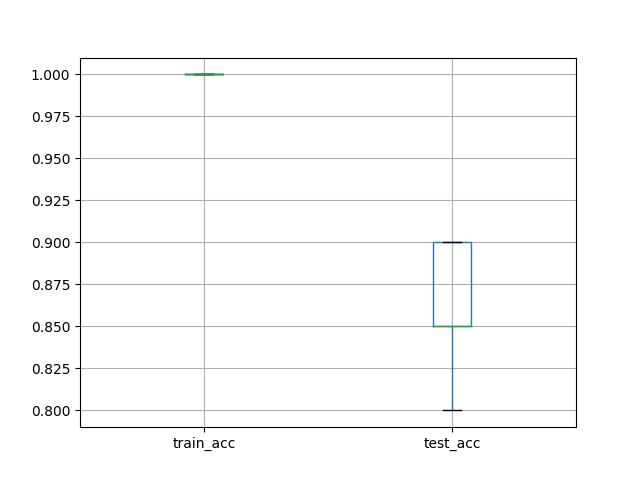

In [17]:
import matplotlib.pyplot as plt
%matplotlib notebook
acc = np.transpose([train_acc, test_acc])
acc = pd.DataFrame(data=acc, columns=['train_acc', 'test_acc'])
boxplot = acc.boxplot(column=['train_acc', 'test_acc'])
plt.show()

In [11]:
acc.describe()

,train_acc,test_acc
count,30.0,30.000000
mean,1.0,0.863333
std,0.0,0.026042
min,1.0,0.800000
25%,1.0,0.850000
50%,1.0,0.850000
75%,1.0,0.900000
max,1.0,0.900000


<IPython.core.display.Javascript object>


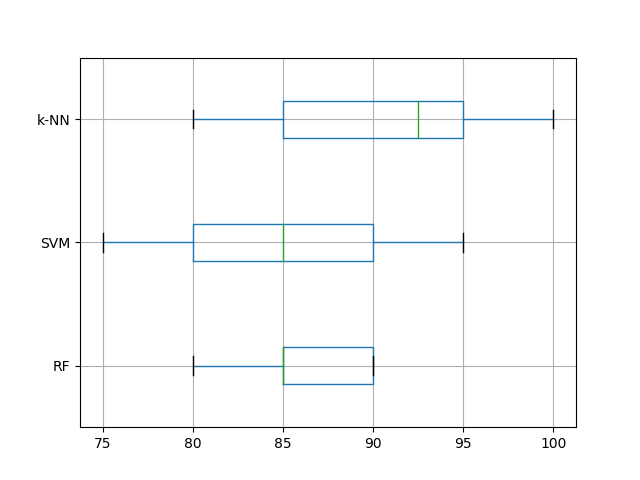

In [22]:
np.array(np.multiply(acc['test_acc'],100))

import matplotlib.pyplot as plt
%matplotlib notebook
acc_traj = pd.DataFrame(data=np.transpose([np.array(np.multiply(acc['test_acc'],100)), 
                                           [85,90,85,85,90,85,80,90,80,90,85,80,90,80,95,95,90,95,80,75,80,95,90,85,90,80,95,85,90,80], [80,95,85,95,85,95,85,90,100,85,85,80,90,95,100,85,80,80,95,90,100,80,90,95,95,95,95,95,95,100]]), columns=['RF', 'SVM', 'k-NN'])
boxplot_traj = acc_traj.boxplot(column=['RF', 'SVM', 'k-NN'], vert=False)
plt.show()